IMB DVS128 Gesture Dataset (http://research.ibm.com/dvsgesture/) contains event-based recordings of 11 gestures made by 29 subjects under 3 different lighting conditions. A series of 11 gestures was recorded for each subject. Each gesture lasts 6 seconds. This work uses a preprocessed version of the original dataset (https://tonic.readthedocs.io/), where recordings that originally contained multiple labels have already been cut into respective samples. Also temporal precision is reduced to ms.

To avoid downloading dataset every session this kernel uses output from another kernel ([https://www.kaggle.com/code/dlarionov/create-dvs128gesture-tonic-dataset](https://www.kaggle.com/code/dlarionov/create-dvs128gesture-tonic-dataset))

This is the first part of the DVS128 Gesture Dataset exploration. It contains solution using spiking neural network implemented with snntorch. The event trace for each gesture is divided into dense frames, which are sequentially fed into a convolutional network containing, instead of the classical activation functions LIF neurons that can take into account the temporal aspect.

In [ ]:
import numpy as np
import numpy.lib.recfunctions as rf
!pip install wandb

In [2]:
# each sequence of gestures for each subject is divided into 11 .npy files, which are named according to the target labels. 
file_name = '/kaggle/input/create-dvs128gesture-tonic-dataset/DVSGesture/ibmGestureTest/user26_led/9.npy'

# each file contains a list of events (x-pos, y-pos, polarity, timestamp).
arr = np.load(file_name)
arr[:, 3] *= 1000  # convert from ms to us
dtype = np.dtype([("x", np.int16), ("y", np.int16), ("p", bool), ("t", np.int64)])
arr = rf.unstructured_to_structured(arr, dtype)

print("A single event:", arr[0], "as (x-pos, y-pos, polarity, timestamp).")

# np.savetxt("./DVSGesture/ibmGestureTest/user26_led/9.csv", arr, delimiter=",") # save as csv

A single event: (55, 103, False, 13) as (x-pos, y-pos, polarity, timestamp).


In [3]:
!pip install tonic 

  Obtaining dependency information for tonic from https://files.pythonhosted.org/packages/08/ab/f59ff68e7603df6b628d411898093e5fdfdf9dae14d26fd8b95cacd1d131/tonic-1.5.0-py3-none-any.whl.metadata
  Obtaining dependency information for importRosbag>=1.0.4 from https://files.pythonhosted.org/packages/c4/ce/04f383b0e250846ab1702caf1d71e6291b56351f98244a78862d072fc4a6/importRosbag-1.0.4-py3-none-any.whl.metadata
  Obtaining dependency information for pbr from https://files.pythonhosted.org/packages/1d/44/6a65ecd630393d47ad3e7d5354768cb7f9a10b3a0eb2cd8c6f52b28211ee/pbr-6.1.0-py2.py3-none-any.whl.metadata
  Obtaining dependency information for expelliarmus from https://files.pythonhosted.org/packages/e8/be/ef7924273a4d254be5dbc66a32ebb73fc739449aea71426cc489a8e103b3/expelliarmus-1.1.12-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.6/116.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━

In [4]:
import tonic
import matplotlib.pyplot as plt
from IPython.display import HTML

def to_frames(events):
     # creates dense frames from events by binning them in different ways
    frame_transform = tonic.transforms.ToFrame(
        sensor_size=tonic.datasets.DVSGesture.sensor_size, 
        #time_window=10000)
        n_time_bins=100)
        #event_count=1000)
    return frame_transform(events)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Train dataset contains 1077 samples.
There are 203956 events in the selected sample.
A single event: (47, 115, True, 5) as (x-pos, y-pos, polarity, timestamp).
(100, 2, 128, 128) 10


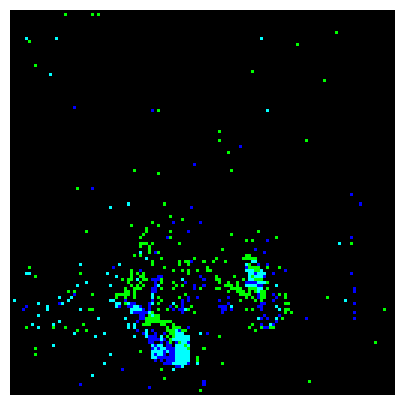

In [5]:
dataset_path = '/kaggle/input/create-dvs128gesture-tonic-dataset'
train = tonic.datasets.DVSGesture(save_to=dataset_path, train=True)
test = tonic.datasets.DVSGesture(save_to=dataset_path, train=False)

events, label = train[0]
frames = to_frames(events)

print("Train dataset contains", len(train), "samples.")
print("There are", len(events), "events in the selected sample.")
print("A single event:", events[0], "as (x-pos, y-pos, polarity, timestamp).")
print (frames.shape, label)

ani = tonic.utils.plot_animation(frames) # plot one frame
HTML(ani.to_jshtml()) # animate all frames

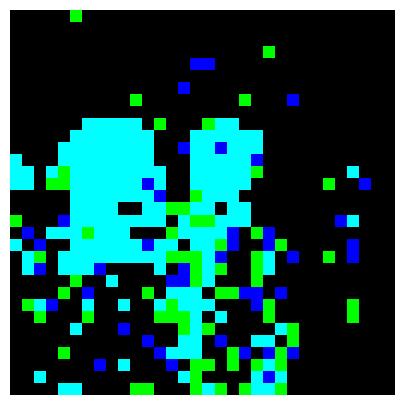

(32, 2, 32, 32) 3


In [6]:
w,h=32,32
n_frames=32 #100
debug = False

transforms = tonic.transforms.Compose([
    tonic.transforms.Denoise(filter_time=10000), # removes outlier events with inactive surrounding pixels for 10ms
    tonic.transforms.Downsample(sensor_size=tonic.datasets.DVSGesture.sensor_size, target_size=(w,h)), # downsampling image
    tonic.transforms.ToFrame(sensor_size=(w,h,2), n_time_bins=n_frames), # n_frames frames per trail
])

train2 = tonic.datasets.DVSGesture(save_to=dataset_path, transform=transforms, train=True)
test2 = tonic.datasets.DVSGesture(save_to=dataset_path, transform=transforms, train=False)

cached_train = train2 if debug else tonic.DiskCachedDataset(train2, cache_path='/temp/dvsgesture/train')
cached_test = test2 if debug else tonic.DiskCachedDataset(test2, cache_path='/temp/dvsgesture/test')

frames, label = cached_train[1]
ani = tonic.utils.plot_animation(frames)
print(frames.shape, label)
HTML(ani.to_jshtml())

In [7]:
!pip install snntorch

  Obtaining dependency information for snntorch from https://files.pythonhosted.org/packages/51/d5/9800809f6e87e4f4b3a4429178f9e6241b94557358738e0932e835fad9e8/snntorch-0.9.1-py2.py3-none-any.whl.metadata
  Obtaining dependency information for nir from https://files.pythonhosted.org/packages/de/21/9ce939c0f046f11686c24f295016e47c328f01090fa638ffd5d72f90911e/nir-1.0.4-py3-none-any.whl.metadata
  Obtaining dependency information for nirtorch from https://files.pythonhosted.org/packages/cd/74/92cc684fd83636b072318693676877af0d80c4e136067237f147f9a18d6f/nirtorch-1.0-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 125.3/125.3 kB 3.8 MB/s eta 0:00:00


In [8]:
import torch
import torch.nn as nn
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
!nvidia-smi

Wed Dec 18 18:25:41 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   40C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [10]:
!pip install plotly torchsummary

  Obtaining dependency information for torchsummary from https://files.pythonhosted.org/packages/7d/18/1474d06f721b86e6a9b9d7392ad68bed711a02f3b61ac43f13c719db50a6/torchsummary-1.5.1-py3-none-any.whl.metadata


In [17]:
grad = snn.surrogate.fast_sigmoid(slope=25) # surrogate.atan()
beta = 0.5

# 12C5-MP2-32C5-MP2-800FC11 https://snntorch.readthedocs.io/en/latest/tutorials/tutorial_7.html
net = nn.Sequential(
    nn.Conv2d(2, 12, 5), # in_channels, out_channels, kernel_size
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    nn.Conv2d(12, 32, 5),
    nn.MaxPool2d(2),
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True),
    nn.Flatten(),
    nn.Linear(800, 11), #800
    snn.Leaky(beta=beta, spike_grad=grad, init_hidden=True, output=True)
).to(device)

def forward_pass(net, data):
    spk_rec = []
    snn.utils.reset(net)  # resets hidden states for all LIF neurons in net
    for step in range(data.size(0)): # data.size(0) = number of time steps
        spk_out, mem_out = net(data[step])
        spk_rec.append(spk_out)
    return torch.stack(spk_rec)

optimizer = torch.optim.Adam(net.parameters(), lr=0.001, betas=(0.9, 0.999))
loss_fn = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

loss_hist = []
acc_hist = []
test_acc_hist = []


In [18]:
def validate_model():
    correct, total = 0, 0  
    for batch, (data, targets) in enumerate(iter(test_loader)): 
        data, targets = data.to(device), targets.to(device) # [n_frames, batch, polarity, x-pos, y-pos] [batch] 
        spk_rec = forward_pass(net, data)         
        correct += SF.accuracy_rate(spk_rec, targets) * data.shape[0]
        total += data.shape[0]
    return correct/total

In [19]:
import wandb
from tqdm import tqdm

In [20]:
# Initialize WandB project
wandb.init(project="your_project_name", config={
    "epochs": 100,
    "batch_size": 64,
    "optimizer": "Adam",
    "loss_fn": "your_loss_fn_name"
})

num_epochs = 100
cnt = 0
loss_hist = []
acc_hist = []
test_acc_hist = []

train_loader = torch.utils.data.DataLoader(cached_train, batch_size=64, shuffle=True, drop_last=True, 
                                           collate_fn=tonic.collation.PadTensors(batch_first=False))
test_loader = torch.utils.data.DataLoader(cached_test, batch_size=32, shuffle=True, drop_last=True, 
                                          collate_fn=tonic.collation.PadTensors(batch_first=False))

# Main training loop with progress bar
for epoch in range(num_epochs):
    epoch_loss = 0
    epoch_acc = 0
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch + 1}/{num_epochs}", unit="batch") as pbar:
        for batch, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)

            net.train()
            # Propagating one batch through the network and evaluating loss
            spk_rec = forward_pass(net, data)
            loss = loss_fn(spk_rec, targets)

            # Gradient calculation + weight update
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update metrics
            epoch_loss += loss.item()
            acc = SF.accuracy_rate(spk_rec, targets)
            epoch_acc += acc

            # Update progress bar
            pbar.set_postfix(loss=loss.item(), accuracy=acc * 100)
            pbar.update(1)

            # Log every few iterations
            if cnt % 50 == 0:
                test_acc = validate_model()
                print(f"\nEpoch {epoch}, Iteration {batch}")
                print(f"Train Loss: {loss.item():.2f}")
                print(f"Train Accuracy: {acc * 100:.2f}%")
                print(f"Test Accuracy: {test_acc * 100:.2f}%\n")

                # Log metrics to WandB
                wandb.log({
                    "Train Loss": loss.item(),
                    "Train Accuracy": acc * 100,
                    "Test Accuracy": test_acc * 100
                })

                test_acc_hist.append(test_acc)

            cnt += 1

    # Average metrics for the epoch
    epoch_loss /= len(train_loader)
    epoch_acc /= len(train_loader)
    wandb.log({
        "Epoch Loss": epoch_loss,
        "Epoch Accuracy": epoch_acc * 100
    })

# Finalize WandB run
wandb.finish()

Epoch 1/100:   6%|▋         | 1/16 [01:10<17:36, 70.46s/batch, accuracy=6.25, loss=2.8]


Epoch 0, Iteration 0
Train Loss: 2.80
Train Accuracy: 6.25%
Test Accuracy: 9.38%



Epoch 4/100:  25%|██▌       | 4/16 [00:15<01:10,  5.91s/batch, accuracy=65.6, loss=0.764]


Epoch 3, Iteration 2
Train Loss: 0.84
Train Accuracy: 54.69%
Test Accuracy: 53.12%



Epoch 7/100:  38%|███▊      | 6/16 [00:01<00:03,  2.50batch/s, accuracy=70.3, loss=0.655]


Epoch 6, Iteration 4
Train Loss: 0.61
Train Accuracy: 68.75%
Test Accuracy: 55.08%



Epoch 10/100:  50%|█████     | 8/16 [00:02<00:03,  2.62batch/s, accuracy=71.9, loss=0.524]


Epoch 9, Iteration 6
Train Loss: 0.50
Train Accuracy: 73.44%
Test Accuracy: 58.20%



Epoch 13/100:  62%|██████▎   | 10/16 [00:02<00:02,  2.56batch/s, accuracy=81.2, loss=0.478]


Epoch 12, Iteration 8
Train Loss: 0.51
Train Accuracy: 71.88%
Test Accuracy: 65.23%



Epoch 16/100:  75%|███████▌  | 12/16 [00:02<00:01,  2.60batch/s, accuracy=75, loss=0.491]  


Epoch 15, Iteration 10
Train Loss: 0.51
Train Accuracy: 76.56%
Test Accuracy: 68.75%



Epoch 19/100:  88%|████████▊ | 14/16 [00:03<00:00,  2.65batch/s, accuracy=82.8, loss=0.414]


Epoch 18, Iteration 12
Train Loss: 0.46
Train Accuracy: 82.81%
Test Accuracy: 78.12%



Epoch 22/100: 100%|██████████| 16/16 [00:03<00:00,  4.78batch/s, accuracy=76.6, loss=0.473]



Epoch 21, Iteration 14
Train Loss: 0.50
Train Accuracy: 82.81%
Test Accuracy: 75.00%



Epoch 26/100:  12%|█▎        | 2/16 [00:01<00:08,  1.71batch/s, accuracy=93.8, loss=0.324]


Epoch 25, Iteration 0
Train Loss: 0.44
Train Accuracy: 84.38%
Test Accuracy: 80.47%



Epoch 29/100:  25%|██▌       | 4/16 [00:01<00:05,  2.32batch/s, accuracy=89.1, loss=0.35] 


Epoch 28, Iteration 2
Train Loss: 0.33
Train Accuracy: 92.19%
Test Accuracy: 78.91%



Epoch 32/100:  38%|███▊      | 6/16 [00:01<00:03,  2.55batch/s, accuracy=95.3, loss=0.338]


Epoch 31, Iteration 4
Train Loss: 0.28
Train Accuracy: 92.19%
Test Accuracy: 80.47%



Epoch 35/100:  50%|█████     | 8/16 [00:02<00:03,  2.61batch/s, accuracy=84.4, loss=0.386]


Epoch 34, Iteration 6
Train Loss: 0.29
Train Accuracy: 93.75%
Test Accuracy: 79.69%



Epoch 38/100:  62%|██████▎   | 10/16 [00:02<00:02,  2.62batch/s, accuracy=96.9, loss=0.305]


Epoch 37, Iteration 8
Train Loss: 0.28
Train Accuracy: 98.44%
Test Accuracy: 84.77%



Epoch 41/100:  75%|███████▌  | 12/16 [00:02<00:01,  2.65batch/s, accuracy=96.9, loss=0.27] 


Epoch 40, Iteration 10
Train Loss: 0.24
Train Accuracy: 98.44%
Test Accuracy: 83.20%



Epoch 44/100:  88%|████████▊ | 14/16 [00:03<00:00,  2.66batch/s, accuracy=96.9, loss=0.267]


Epoch 43, Iteration 12
Train Loss: 0.24
Train Accuracy: 98.44%
Test Accuracy: 80.86%



Epoch 47/100: 100%|██████████| 16/16 [00:03<00:00,  4.63batch/s, accuracy=96.9, loss=0.241]



Epoch 46, Iteration 14
Train Loss: 0.25
Train Accuracy: 95.31%
Test Accuracy: 82.81%



Epoch 51/100:  12%|█▎        | 2/16 [00:01<00:08,  1.74batch/s, accuracy=100, loss=0.214]


Epoch 50, Iteration 0
Train Loss: 0.19
Train Accuracy: 100.00%
Test Accuracy: 85.55%



Epoch 54/100:  25%|██▌       | 4/16 [00:01<00:05,  2.17batch/s, accuracy=96.9, loss=0.229]


Epoch 53, Iteration 2
Train Loss: 0.19
Train Accuracy: 100.00%
Test Accuracy: 86.33%



Epoch 57/100:  38%|███▊      | 6/16 [00:01<00:04,  2.43batch/s, accuracy=96.9, loss=0.211]


Epoch 56, Iteration 4
Train Loss: 0.21
Train Accuracy: 98.44%
Test Accuracy: 83.59%



Epoch 60/100:  50%|█████     | 8/16 [00:02<00:03,  2.55batch/s, accuracy=96.9, loss=0.194]


Epoch 59, Iteration 6
Train Loss: 0.17
Train Accuracy: 98.44%
Test Accuracy: 86.33%



Epoch 63/100:  62%|██████▎   | 10/16 [00:02<00:02,  2.64batch/s, accuracy=100, loss=0.221]


Epoch 62, Iteration 8
Train Loss: 0.21
Train Accuracy: 95.31%
Test Accuracy: 85.16%



Epoch 66/100:  75%|███████▌  | 12/16 [00:02<00:01,  2.68batch/s, accuracy=100, loss=0.178] 


Epoch 65, Iteration 10
Train Loss: 0.20
Train Accuracy: 98.44%
Test Accuracy: 86.33%



Epoch 69/100:  88%|████████▊ | 14/16 [00:03<00:00,  2.68batch/s, accuracy=100, loss=0.167] 


Epoch 68, Iteration 12
Train Loss: 0.15
Train Accuracy: 100.00%
Test Accuracy: 87.50%



Epoch 72/100: 100%|██████████| 16/16 [00:03<00:00,  4.80batch/s, accuracy=100, loss=0.161] 



Epoch 71, Iteration 14
Train Loss: 0.20
Train Accuracy: 100.00%
Test Accuracy: 87.50%



Epoch 76/100:  12%|█▎        | 2/16 [00:01<00:08,  1.75batch/s, accuracy=95.3, loss=0.231]


Epoch 75, Iteration 0
Train Loss: 0.16
Train Accuracy: 98.44%
Test Accuracy: 85.16%



Epoch 79/100:  25%|██▌       | 4/16 [00:01<00:05,  2.13batch/s, accuracy=98.4, loss=0.148]


Epoch 78, Iteration 2
Train Loss: 0.18
Train Accuracy: 100.00%
Test Accuracy: 86.33%



Epoch 82/100:  38%|███▊      | 6/16 [00:01<00:04,  2.45batch/s, accuracy=98.4, loss=0.158]


Epoch 81, Iteration 4
Train Loss: 0.17
Train Accuracy: 96.88%
Test Accuracy: 86.72%



Epoch 85/100:  50%|█████     | 8/16 [00:02<00:03,  2.56batch/s, accuracy=100, loss=0.176] 


Epoch 84, Iteration 6
Train Loss: 0.14
Train Accuracy: 100.00%
Test Accuracy: 88.28%



Epoch 88/100:  62%|██████▎   | 10/16 [00:02<00:02,  2.68batch/s, accuracy=96.9, loss=0.196]


Epoch 87, Iteration 8
Train Loss: 0.16
Train Accuracy: 100.00%
Test Accuracy: 86.72%



Epoch 91/100:  75%|███████▌  | 12/16 [00:02<00:01,  2.65batch/s, accuracy=98.4, loss=0.172]


Epoch 90, Iteration 10
Train Loss: 0.16
Train Accuracy: 100.00%
Test Accuracy: 86.72%



Epoch 94/100:  88%|████████▊ | 14/16 [00:03<00:00,  2.58batch/s, accuracy=100, loss=0.157]


Epoch 93, Iteration 12
Train Loss: 0.15
Train Accuracy: 100.00%
Test Accuracy: 86.72%



Epoch 97/100: 100%|██████████| 16/16 [00:03<00:00,  4.68batch/s, accuracy=100, loss=0.142] 



Epoch 96, Iteration 14
Train Loss: 0.15
Train Accuracy: 100.00%
Test Accuracy: 87.50%



Epoch 100/100: 100%|██████████| 16/16 [00:02<00:00,  5.55batch/s, accuracy=96.9, loss=0.201]


Epoch Accuracy,▁▄▅▅▆▆▆▆▇▇▇▇▇█▇█████████████████████████
Epoch Loss,█▄▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Test Accuracy,▁▅▅▅▆▆▇▇▇▇▇▇██▇█████████████████
Train Accuracy,▁▅▆▆▆▆▇▇▇▇▇█████████████████████
Train Loss,█▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
Epoch Accuracy,99.51172
Epoch Loss,0.14871
Test Accuracy,87.5
Train Accuracy,100.0
Train Loss,0.14839


/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


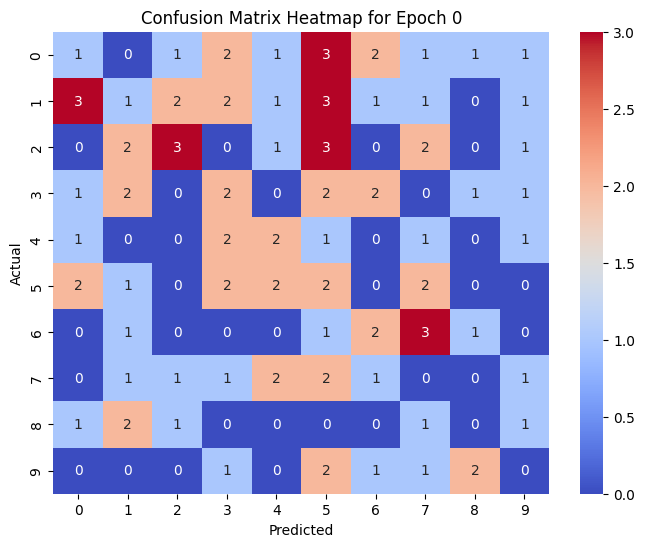

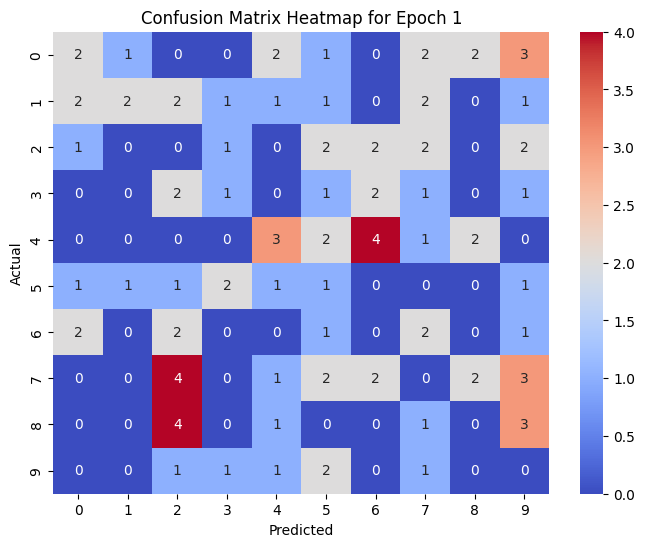

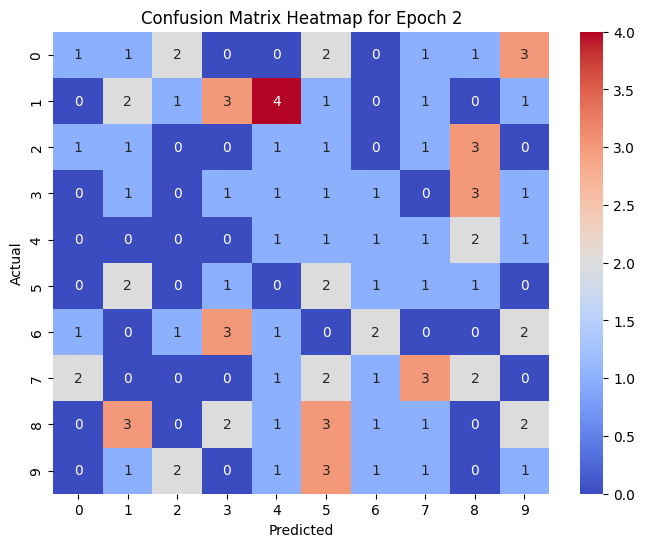

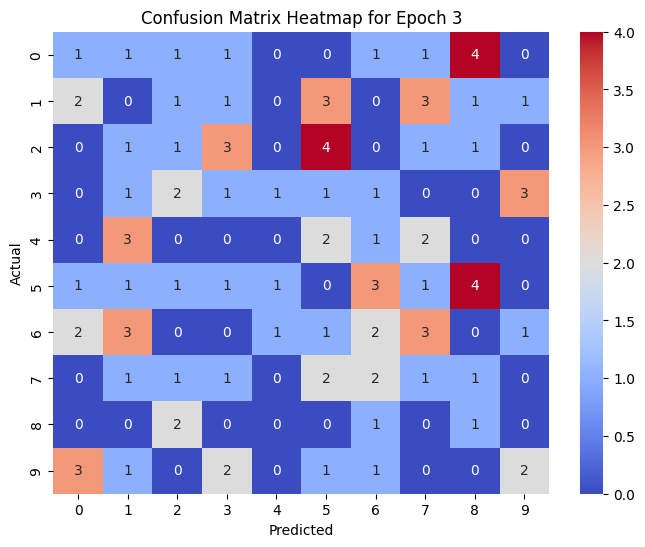

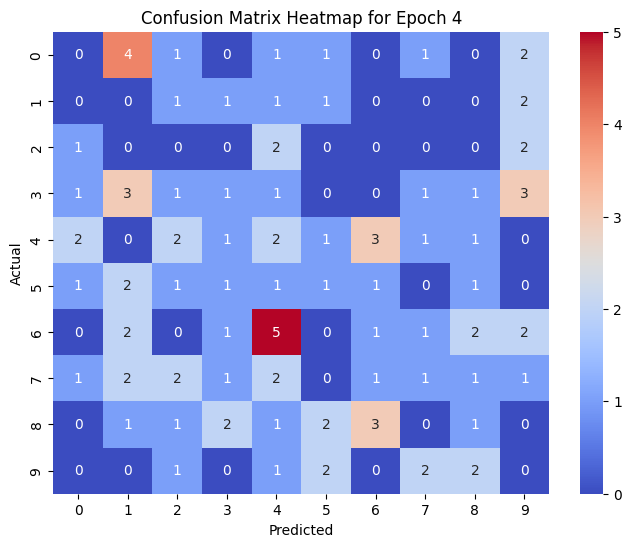

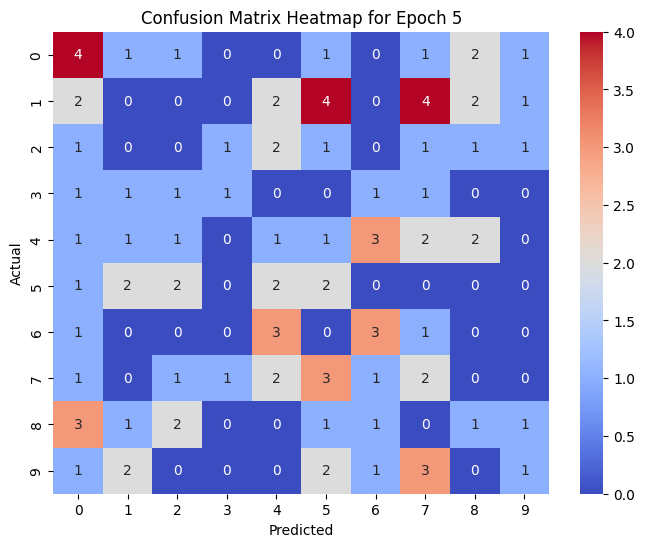

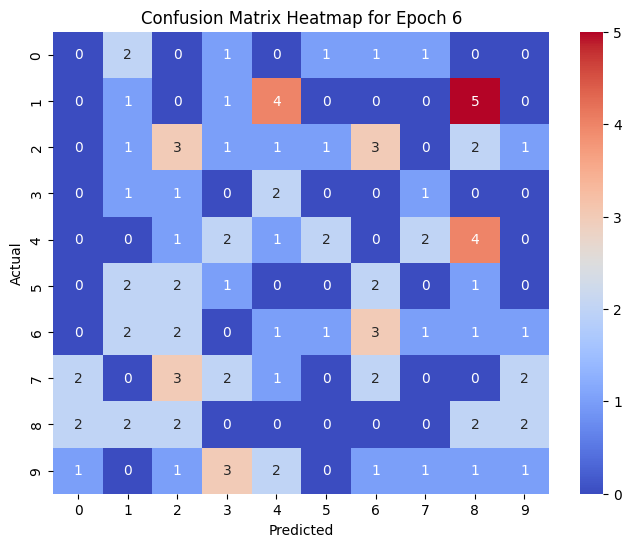

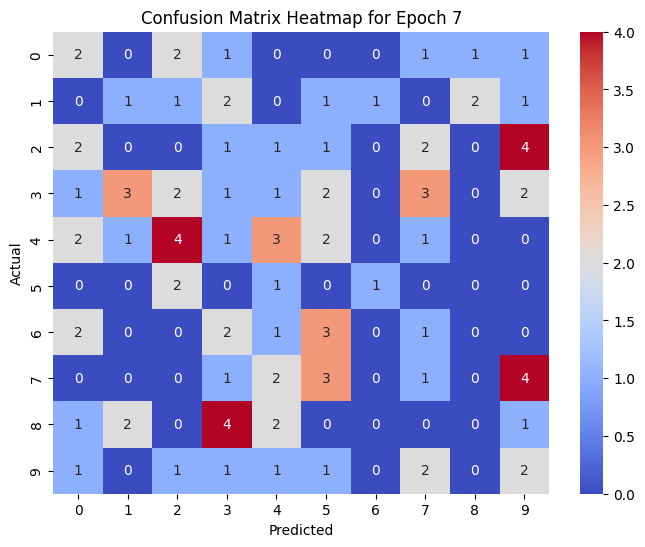

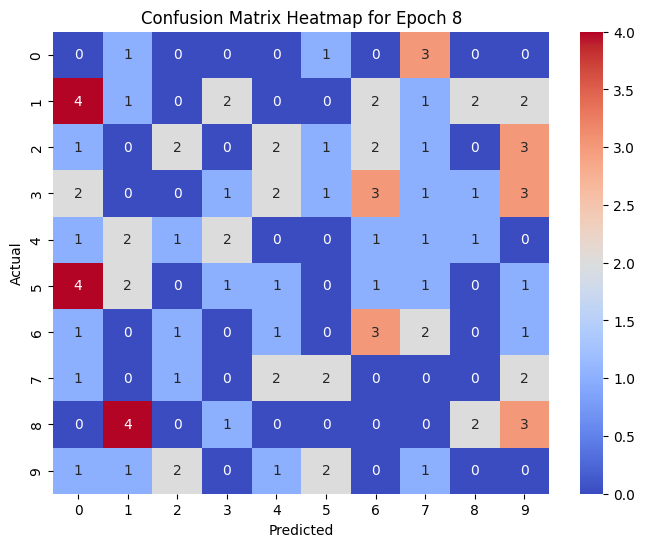

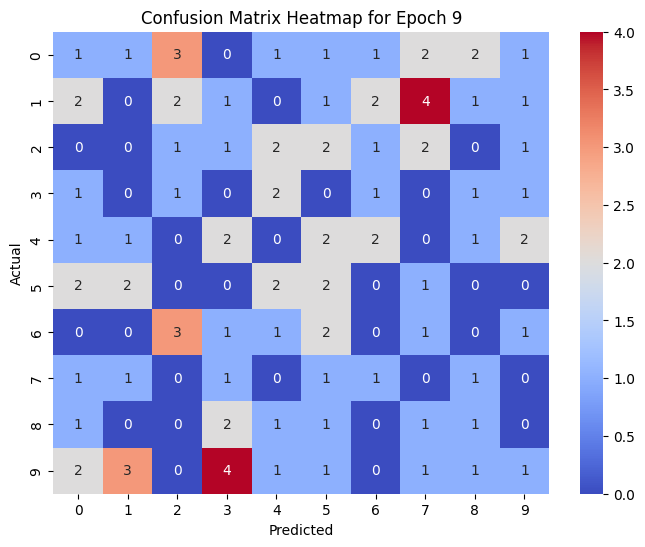

Train Loss Variance: 0.0013, Train Loss Std: 0.0356
Train Accuracy Variance: 0.0008, Train Accuracy Std: 0.0290


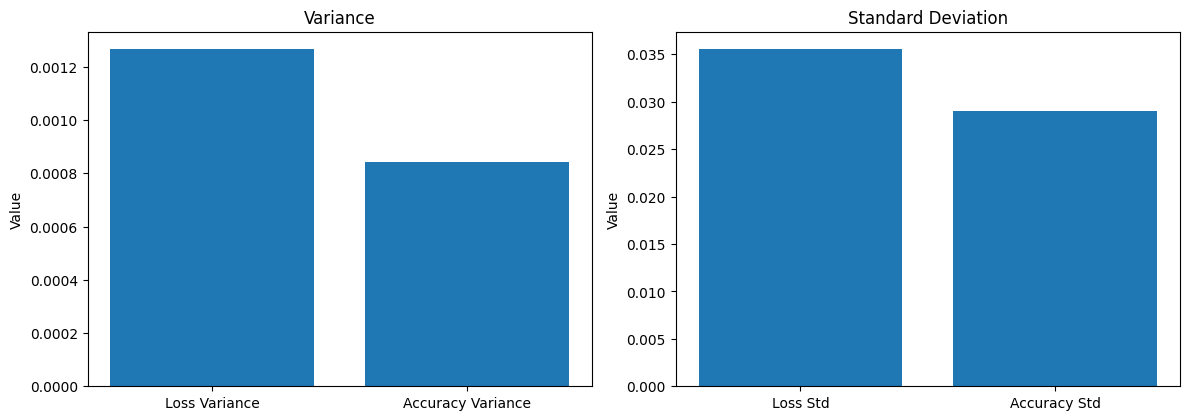

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix




# Tracking metrics
train_losses = []
train_accuracies = []
test_accuracies = []

# Training and timing
num_epochs = 10
training_start = time.time()

for epoch in range(num_epochs):
    epoch_losses = []
    epoch_accuracies = []

    # Simulated training loop (replace with actual model training)
    for batch_idx in range(100):  # Simulate 100 batches
        # Simulate loss and accuracy
        loss = np.random.rand()
        accuracy = np.random.rand()

        epoch_losses.append(loss)
        epoch_accuracies.append(accuracy)

    # Record metrics for each epoch
    train_losses.append(np.mean(epoch_losses))
    train_accuracies.append(np.mean(epoch_accuracies))

    # Simulated test accuracy (replace with actual model testing)
    test_accuracy = np.random.rand()
    test_accuracies.append(test_accuracy)

    # Simulated confusion matrix for heatmap (replace with real predictions and labels)
    y_true = np.random.randint(0, 10, 100)
    y_pred = np.random.randint(0, 10, 100)
    conf_matrix = confusion_matrix(y_true, y_pred)

    # # Generate heatmap for confusion matrix
    # plt.figure(figsize=(8, 6))
    # sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm')
    # plt.title(f'Confusion Matrix for Epoch {epoch + 1}')
    # plt.xlabel('Predicted')
    # plt.ylabel('Actual')
    # plt.show()

    # Inside your loop
    conf_matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm")
    plt.title(f"Confusion Matrix Heatmap for Epoch {epoch}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()


# Calculating variance and standard deviation
train_loss_variance = np.var(train_losses)
train_loss_std = np.std(train_losses)
train_accuracy_variance = np.var(train_accuracies)
train_accuracy_std = np.std(train_accuracies)

print(f"Train Loss Variance: {train_loss_variance:.4f}, Train Loss Std: {train_loss_std:.4f}")
print(f"Train Accuracy Variance: {train_accuracy_variance:.4f}, Train Accuracy Std: {train_accuracy_std:.4f}")

# Plotting metrics
epochs = range(1, num_epochs + 1)

plt.figure(figsize=(12, 8))
# Loss plot


# Variance plot
plt.subplot(2, 2, 3)
plt.bar(["Loss Variance", "Accuracy Variance"], [train_loss_variance, train_accuracy_variance])
plt.title("Variance")
plt.ylabel("Value")

# Standard deviation plot
plt.subplot(2, 2, 4)
plt.bar(["Loss Std", "Accuracy Std"], [train_loss_std, train_accuracy_std])
plt.title("Standard Deviation")
plt.ylabel("Value")

plt.tight_layout()
plt.show()


In [22]:
validate_model(), np.max(test_acc_hist)

(0.87109375, 0.8828125)